# Tutorial for NIRCam post-pipeline contrast analyses using spaceKLIP

In this notebook we will analyze the NIRCam coronagraphy data on HIP 65426 b 
from the JWST ERS program on Direct Observations of Exoplanetary Systems, program 1386. 


<div class="alert alert-block alert-warning">
This notebook has been modified to work on HD 141569A ERS data
</div>

## Setup and imports

In [1]:
import os
import pdb
import sys
import glob

import numpy as np
import astropy.io.fits as fits
import astropy.table

import matplotlib.pyplot as plt
import matplotlib

import spaceKLIP

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-062 CANNOT BE CHECKED AGAINST ONLINE VERSION


Note that currently the import of `webbpsf_ext` has a side effect of configuring extra verbose logging. We're not interested in that logging text, so let's quiet it. 

In [2]:
import webbpsf_ext
webbpsf_ext.setup_logging('WARN', verbose=False)

In [3]:
idir = '/home/maxmb/Library/jwst_hd141569a_lib/data/F300M/jk/231108/for_planet_sensitivity/'
odir = idir+'spaceklip/'

## Re-read level 3 outputs into database 
Read in output files produced in the NIRCam coronagraph data reduction notebook. 

In [4]:
fitsfiles = sorted([idir + f for f in os.listdir(idir)
                if f.endswith('.fits')])


# Initialize spaceKLIP database.
database = spaceKLIP.database.Database(output_dir=odir)

# Read FITS files.
database.read_jwst_s012_data(datapaths=fitsfiles,
                                bgpaths=None)

[spaceKLIP.database:INFO] --> Identified 1 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R
TYPE  EXP_TYPE DATAMODL TELESCOP ... BUNIT       ROLL_REF      BLURFWHM
---- --------- -------- -------- ... ------ ------------------ --------
 SCI NRC_CORON   STAGE2     JWST ... MJy/sr 284.81837365356836      nan
 SCI NRC_CORON   STAGE2     JWST ... MJy/sr 279.81907801898586      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr 282.51312727233596      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr  282.5131275595942      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr   282.513138623121      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr 282.51313035059627      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr  282.5131338259995      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr  282.5131356262706      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr  282.5131323843138      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr

In [5]:
ImageTools = spaceKLIP.imagetools.ImageTools(database=database)
ImageTools.crop_frames(npix=80,
                           types=['SCI', 'SCI_BG', 'REF', 'REF_BG'],
                           subdir='cropped')

ImageTools.align_frames(method='fourier',
                        kwargs={},
                        subdir='aligned')

# Coadd frames.
ImageTools.coadd_frames(nframes=None,
                        types=['SCI', 'REF'],
                        subdir='coadded')

[spaceKLIP.imagetools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.imagetools:INFO]   --> Frame cropping: jw01386117001_03106_00001_nrcalong_calints_mstar_subtracted_disk_subtracted.fits
[spaceKLIP.imagetools:INFO]   --> Frame cropping: old shape = (320, 320), new shape = (160, 160)
[spaceKLIP.imagetools:INFO]   --> Frame cropping: jw01386118001_03106_00001_nrcalong_calints_mstar_subtracted_disk_subtracted.fits
[spaceKLIP.imagetools:INFO]   --> Frame cropping: old shape = (320, 320), new shape = (160, 160)
[spaceKLIP.imagetools:INFO]   --> Frame cropping: jw01386116001_03106_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Frame cropping: old shape = (320, 320), new shape = (160, 160)
[spaceKLIP.imagetools:INFO]   --> Frame cropping: jw01386116001_03106_00002_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Frame cropping: old shape = (320, 320), new shape = (160, 160)
[spaceKLIP.imagetools:INFO]   --> Frame cropping: jw

In [6]:
kwargs = {'mode': ['RDI','ADI+RDI','ADI'],
              'annuli': [1,5,20],
              'subsections': [1,4,6],
              'numbasis': [1, 5, 10, 20],
              'highpass': 3,
              'OWA': 80,1
              'algo': 'klip',}
klip_dir = 'klipsub_final_240221'
spaceKLIP.pyklippipeline.run_obs(database=database,
                        kwargs=kwargs,
                        subdir=klip_dir,)

SyntaxError: ':' expected after dictionary key (36875380.py, line 6)

## Contrast Calculations

Here we use the analysistools module to measure contrast

### Preparation: Stellar Photometry Model

A model of the target star is needed to compute its flux in the observational filters, and thereby produce a reference point from which to determine our contrast performance. This requires an input that gives either **(a)** the host star photometry, formatted as a [Vizier](http://vizier.cds.unistra.fr) VOTable, or **(b)** a simple text file with two columns giving wavelenth in microns and flux in Jy.


If you need to obtain you own version of option **(a)**, head to Vizier's [Photometry Viewer](http://vizier.cds.unistra.fr/vizier/sed/) and input your target of interest. However, exercise caution as this search can introduce spurious photometry measurements from nearby sources, which are realised as sharp variations in flux that do not agree with the expected profile of the targets spectral energy distribution. You may need to clean the obtained data by reducing the search radius, or manually removing individual points using the checkboxes in the table at the bottom. Once you are happy, click \"Download Data\" to obtain a VOTable that can be directly ingested into spaceKLIP. Option **(b)** could be instead be produced, for instance, from fitting a scaled version of a stellar atmosphere model to available photometry.

We provide here examples of both kinds of file, provided by Aarynn Carter. _Only one is needed; we provide both purely as examples._

In [ ]:
fitsfiles = sorted(glob.glob(os.path.join(odir, klip_dir,"*KLmodes-all.fits")))

Database = spaceKLIP.database.Database(output_dir=odir)
Database.read_jwst_s3_data(fitsfiles)

[spaceKLIP.database:INFO] --> Identified 1 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R
 TYPE   EXP_TYPE DATAMODL TELESCOP ... SUBSECTS  KLMODES  BUNIT  BLURFWHM
------ --------- -------- -------- ... -------- --------- ------ --------
PYKLIP NRC_CORON   STAGE3     JWST ...        1 1,5,10,20 MJy/sr      nan
PYKLIP NRC_CORON   STAGE3     JWST ...        4 1,5,10,20 MJy/sr      nan
PYKLIP NRC_CORON   STAGE3     JWST ...        6 1,5,10,20 MJy/sr      nan
PYKLIP NRC_CORON   STAGE3     JWST ...        1 1,5,10,20 MJy/sr      nan
PYKLIP NRC_CORON   STAGE3     JWST ...        4 1,5,10,20 MJy/sr      nan
PYKLIP NRC_CORON   STAGE3     JWST ...        6 1,5,10,20 MJy/sr      nan
PYKLIP NRC_CORON   STAGE3     JWST ...        1 1,5,10,20 MJy/sr      nan
PYKLIP NRC_CORON   STAGE3     JWST ...        4 1,5,10,20 MJy/sr      nan
PYKLIP NRC_CORON   STAGE3     JWST ...        6 1,5,10,20 MJy/sr      nan
PYKLIP NRC_CORON   ST

In [ ]:
star_photometry_vot = 'hd_141569.vot'

In [ ]:
import astropy

# Read in VOT version
vot_version = astropy.table.Table.read(star_photometry_vot)

# convert from freq to wl, just for plotting below.
vot_version['wavelength'] = (astropy.constants.c /  vot_version['sed_freq']).to(astropy.units.micron)

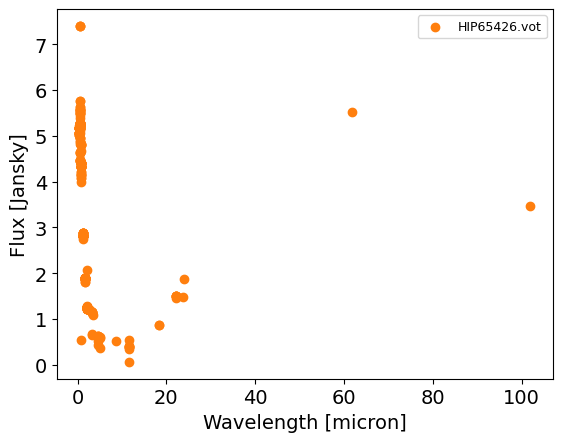

In [ ]:
# plot, to show the two models are consistent

# plt.semilogx(txt_version['wavelength'], txt_version['flux'], label='HIP65426A_sdf_phoenix_m+modbb_disk_r.txt',)
plt.scatter(vot_version['wavelength'], vot_version['sed_flux'], label='HIP65426.vot', color='C1')

plt.xlabel("Wavelength [micron]")
plt.ylabel("Flux [Jansky]")
plt.legend(fontsize=9)
plt.show()


## Set up Analysis Tools

We initialize the AnalysisTools class and provide it the database of files to be analyzed. 

In [ ]:
# Initialize the spaceKLIP contrast estimation class.
analysistools = spaceKLIP.analysistools.AnalysisTools(Database)


## Compute Raw Contrasts

This iterates over all filters and datasets.

In [ ]:
# Compute raw contrast.
contrast_subdir = os.path.join("contrast_curves","rawcon")
analysistools.raw_contrast(starfile='hd_141569.vot',
                               spectral_type='A2V',
                               subdir = contrast_subdir)


[spaceKLIP.analysistools:INFO] Copying starfile hd_141569.vot to /home/maxmb/Library/jwst_hd141569a_lib/data/F300M/jk/231108/for_planet_sensitivity/spaceklip/contrast_curves/rawcon/hd_141569.vot
[spaceKLIP.analysistools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.analysistools:INFO] Analyzing file /home/maxmb/Library/jwst_hd141569a_lib/data/F300M/jk/231108/for_planet_sensitivity/spaceklip/klipsub_final_240221/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits


[spaceKLIP.psf:INFO]   --> Generating WebbPSF model
[spaceKLIP.analysistools:INFO]   Measuring raw contrast in annuli
[spaceKLIP.analysistools:INFO]   Measuring raw contrast for masked data
Contrast results and plots saved to /home/maxmb/Library/jwst_hd141569a_lib/data/F300M/jk/231108/for_planet_sensitivity/spaceklip/contrast_curves/rawcon/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all_seps.npy, /home/maxmb/Library/jwst_hd141569a_lib/data/F300M/jk/231108/for_planet_sensitivity/spaceklip/contrast_curves/rawcon/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cons.npy
[spaceKLIP.analysistools:INFO] Analyzing file /home/maxmb/Library/jwst_hd141569a_lib/data/F300M/jk/231108/for_planet_sensitivity/spaceklip/klipsub_final_240221/ADI+RDI_NANNU1_NSUBS4_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
[spaceKLIP.psf:INFO]   --> Generating WebbPSF model
[spaceKLIP.analysistools:INFO]   Mea

The output of these is a large set of files within the `rawcon` subdir of the data directory. This includes PDFs showing the reduced images, and plots of contrast, and also saved contrast curves. 

Previously, raw contrast curves were saved as `.npy` numpy data dump files; now they are saved as astropy ECSV format text files, for easy use with astropy.table. 

In [ ]:
# astropy.table.Table.read(input_dir+'/contrast_curves/rawcon/ADI+RDI_NANNU20_NSUBS6_JWST_NIRCAM_NRCALONG_F360M_MASKRND_MASK335R_SUB320A335R-KLmodes-all_contrast.ecsv')

In [ ]:
fitsfiles = sorted(glob.glob(os.path.join(odir, klip_dir,"*KLmodes-all.fits")))

database = spaceKLIP.database.Database(output_dir=odir)
database.read_jwst_s3_data(fitsfiles)
analysistools = spaceKLIP.analysistools.AnalysisTools(database)

#Compute calibrated contrast.
analysistools.calibrate_contrast(rawcon_subdir=os.path.join(odir+contrast_subdir), #Directory raw contrast was saved to
                                #  companions=[[comp_dra, comp_ddec, 2.]],  #[RA offset (arcsec), Dec offset (arcsec), mask radius (lambda/D)] for companions to avoid injecting too close
                                 injection_seps=[0.5, 1, 2, 3], # Separations to inject and recover companions (arcsec), can also be 'default'
                                 injection_pas=[45], # PAs to inject and recover companions (degrees), can also be 'default'
                                 injection_flux_sigma=20, #N sigma flux of injected companion relative to contrast of median KL mode subtraction (default 20)
                                 multi_injection_spacing=None, #Spacing between injected companion, None = 1 companion per injection+recovery.
                                 use_saved=False,
                                 highpass=kwargs['highpass']) # whether to run the companion injection, or load saved files.


[spaceKLIP.database:INFO] --> Identified 1 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R
 TYPE   EXP_TYPE DATAMODL TELESCOP ... SUBSECTS  KLMODES  BUNIT  BLURFWHM
------ --------- -------- -------- ... -------- --------- ------ --------
PYKLIP NRC_CORON   STAGE3     JWST ...        1 1,5,10,20 MJy/sr      nan
PYKLIP NRC_CORON   STAGE3     JWST ...        4 1,5,10,20 MJy/sr      nan
PYKLIP NRC_CORON   STAGE3     JWST ...        6 1,5,10,20 MJy/sr      nan
PYKLIP NRC_CORON   STAGE3     JWST ...        1 1,5,10,20 MJy/sr      nan
PYKLIP NRC_CORON   STAGE3     JWST ...        4 1,5,10,20 MJy/sr      nan
PYKLIP NRC_CORON   STAGE3     JWST ...        6 1,5,10,20 MJy/sr      nan
PYKLIP NRC_CORON   STAGE3     JWST ...        1 1,5,10,20 MJy/sr      nan
PYKLIP NRC_CORON   STAGE3     JWST ...        4 1,5,10,20 MJy/sr      nan
PYKLIP NRC_CORON   STAGE3     JWST ...        6 1,5,10,20 MJy/sr      nan
PYKLIP NRC_CORON   ST

[spaceKLIP.psf:INFO]   --> Generating WebbPSF model
[spaceKLIP.analysistools:INFO] Analyzing file /home/maxmb/Library/jwst_hd141569a_lib/data/F300M/jk/231108/for_planet_sensitivity/spaceklip/klipsub_final_240221/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
--> Rejected 0 of 2 images due to too many bad pixels (threshold = 100%)
--> Rejected 0 of 9 images due to too many bad pixels (threshold = 100%)
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 4 source positions suitable for injection.


  0%|          | 0/4 [00:00<?, ?it/s]

[spaceKLIP.analysistools:INFO] Analyzing file /home/maxmb/Library/jwst_hd141569a_lib/data/F300M/jk/231108/for_planet_sensitivity/spaceklip/klipsub_final_240221/ADI+RDI_NANNU1_NSUBS4_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
--> Rejected 0 of 2 images due to too many bad pixels (threshold = 100%)
--> Rejected 0 of 9 images due to too many bad pixels (threshold = 100%)
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 4 source positions suitable for injection.


  0%|          | 0/4 [00:00<?, ?it/s]

[spaceKLIP.analysistools:INFO] Analyzing file /home/maxmb/Library/jwst_hd141569a_lib/data/F300M/jk/231108/for_planet_sensitivity/spaceklip/klipsub_final_240221/ADI+RDI_NANNU1_NSUBS6_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
--> Rejected 0 of 2 images due to too many bad pixels (threshold = 100%)
--> Rejected 0 of 9 images due to too many bad pixels (threshold = 100%)
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 4 source positions suitable for injection.


  0%|          | 0/4 [00:00<?, ?it/s]

[spaceKLIP.analysistools:INFO] Analyzing file /home/maxmb/Library/jwst_hd141569a_lib/data/F300M/jk/231108/for_planet_sensitivity/spaceklip/klipsub_final_240221/ADI+RDI_NANNU20_NSUBS1_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
--> Rejected 0 of 2 images due to too many bad pixels (threshold = 100%)
--> Rejected 0 of 9 images due to too many bad pixels (threshold = 100%)
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 4 source positions suitable for injection.


  0%|          | 0/4 [00:00<?, ?it/s]

[spaceKLIP.analysistools:INFO] Analyzing file /home/maxmb/Library/jwst_hd141569a_lib/data/F300M/jk/231108/for_planet_sensitivity/spaceklip/klipsub_final_240221/ADI+RDI_NANNU20_NSUBS4_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
--> Rejected 0 of 2 images due to too many bad pixels (threshold = 100%)
--> Rejected 0 of 9 images due to too many bad pixels (threshold = 100%)
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 4 source positions suitable for injection.


  0%|          | 0/4 [00:00<?, ?it/s]

[spaceKLIP.analysistools:INFO] Analyzing file /home/maxmb/Library/jwst_hd141569a_lib/data/F300M/jk/231108/for_planet_sensitivity/spaceklip/klipsub_final_240221/ADI+RDI_NANNU20_NSUBS6_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
--> Rejected 0 of 2 images due to too many bad pixels (threshold = 100%)
--> Rejected 0 of 9 images due to too many bad pixels (threshold = 100%)
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 4 source positions suitable for injection.


  0%|          | 0/4 [00:00<?, ?it/s]

[spaceKLIP.analysistools:INFO] Analyzing file /home/maxmb/Library/jwst_hd141569a_lib/data/F300M/jk/231108/for_planet_sensitivity/spaceklip/klipsub_final_240221/ADI+RDI_NANNU5_NSUBS1_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
--> Rejected 0 of 2 images due to too many bad pixels (threshold = 100%)
--> Rejected 0 of 9 images due to too many bad pixels (threshold = 100%)
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 4 source positions suitable for injection.


  0%|          | 0/4 [00:00<?, ?it/s]

[spaceKLIP.analysistools:INFO] Analyzing file /home/maxmb/Library/jwst_hd141569a_lib/data/F300M/jk/231108/for_planet_sensitivity/spaceklip/klipsub_final_240221/ADI+RDI_NANNU5_NSUBS4_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
--> Rejected 0 of 2 images due to too many bad pixels (threshold = 100%)
--> Rejected 0 of 9 images due to too many bad pixels (threshold = 100%)
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 4 source positions suitable for injection.


  0%|          | 0/4 [00:00<?, ?it/s]

[spaceKLIP.analysistools:INFO] Analyzing file /home/maxmb/Library/jwst_hd141569a_lib/data/F300M/jk/231108/for_planet_sensitivity/spaceklip/klipsub_final_240221/ADI+RDI_NANNU5_NSUBS6_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
--> Rejected 0 of 2 images due to too many bad pixels (threshold = 100%)
--> Rejected 0 of 9 images due to too many bad pixels (threshold = 100%)
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 4 source positions suitable for injection.


  0%|          | 0/4 [00:00<?, ?it/s]

[spaceKLIP.analysistools:INFO] Analyzing file /home/maxmb/Library/jwst_hd141569a_lib/data/F300M/jk/231108/for_planet_sensitivity/spaceklip/klipsub_final_240221/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
--> Rejected 0 of 2 images due to too many bad pixels (threshold = 100%)
--> Rejected 0 of 9 images due to too many bad pixels (threshold = 100%)
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 4 source positions suitable for injection.


  0%|          | 0/4 [00:00<?, ?it/s]

[spaceKLIP.analysistools:INFO] Analyzing file /home/maxmb/Library/jwst_hd141569a_lib/data/F300M/jk/231108/for_planet_sensitivity/spaceklip/klipsub_final_240221/ADI_NANNU1_NSUBS4_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
--> Rejected 0 of 2 images due to too many bad pixels (threshold = 100%)
--> Rejected 0 of 9 images due to too many bad pixels (threshold = 100%)
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 4 source positions suitable for injection.


  0%|          | 0/4 [00:00<?, ?it/s]

[spaceKLIP.analysistools:INFO] Analyzing file /home/maxmb/Library/jwst_hd141569a_lib/data/F300M/jk/231108/for_planet_sensitivity/spaceklip/klipsub_final_240221/ADI_NANNU1_NSUBS6_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
--> Rejected 0 of 2 images due to too many bad pixels (threshold = 100%)
--> Rejected 0 of 9 images due to too many bad pixels (threshold = 100%)
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 4 source positions suitable for injection.


  0%|          | 0/4 [00:00<?, ?it/s]

[spaceKLIP.analysistools:INFO] Analyzing file /home/maxmb/Library/jwst_hd141569a_lib/data/F300M/jk/231108/for_planet_sensitivity/spaceklip/klipsub_final_240221/ADI_NANNU20_NSUBS1_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
--> Rejected 0 of 2 images due to too many bad pixels (threshold = 100%)
--> Rejected 0 of 9 images due to too many bad pixels (threshold = 100%)
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 4 source positions suitable for injection.


  0%|          | 0/4 [00:00<?, ?it/s]

[spaceKLIP.analysistools:INFO] Analyzing file /home/maxmb/Library/jwst_hd141569a_lib/data/F300M/jk/231108/for_planet_sensitivity/spaceklip/klipsub_final_240221/ADI_NANNU20_NSUBS4_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
--> Rejected 0 of 2 images due to too many bad pixels (threshold = 100%)
--> Rejected 0 of 9 images due to too many bad pixels (threshold = 100%)
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 4 source positions suitable for injection.


  0%|          | 0/4 [00:00<?, ?it/s]

[spaceKLIP.analysistools:INFO] Analyzing file /home/maxmb/Library/jwst_hd141569a_lib/data/F300M/jk/231108/for_planet_sensitivity/spaceklip/klipsub_final_240221/ADI_NANNU20_NSUBS6_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
--> Rejected 0 of 2 images due to too many bad pixels (threshold = 100%)
--> Rejected 0 of 9 images due to too many bad pixels (threshold = 100%)
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 4 source positions suitable for injection.


  0%|          | 0/4 [00:00<?, ?it/s]

[spaceKLIP.analysistools:INFO] Analyzing file /home/maxmb/Library/jwst_hd141569a_lib/data/F300M/jk/231108/for_planet_sensitivity/spaceklip/klipsub_final_240221/ADI_NANNU5_NSUBS1_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
--> Rejected 0 of 2 images due to too many bad pixels (threshold = 100%)
--> Rejected 0 of 9 images due to too many bad pixels (threshold = 100%)
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 4 source positions suitable for injection.


  0%|          | 0/4 [00:00<?, ?it/s]

[spaceKLIP.analysistools:INFO] Analyzing file /home/maxmb/Library/jwst_hd141569a_lib/data/F300M/jk/231108/for_planet_sensitivity/spaceklip/klipsub_final_240221/ADI_NANNU5_NSUBS4_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
--> Rejected 0 of 2 images due to too many bad pixels (threshold = 100%)
--> Rejected 0 of 9 images due to too many bad pixels (threshold = 100%)
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 4 source positions suitable for injection.


  0%|          | 0/4 [00:00<?, ?it/s]

[spaceKLIP.analysistools:INFO] Analyzing file /home/maxmb/Library/jwst_hd141569a_lib/data/F300M/jk/231108/for_planet_sensitivity/spaceklip/klipsub_final_240221/ADI_NANNU5_NSUBS6_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
--> Rejected 0 of 2 images due to too many bad pixels (threshold = 100%)
--> Rejected 0 of 9 images due to too many bad pixels (threshold = 100%)
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 4 source positions suitable for injection.


  0%|          | 0/4 [00:00<?, ?it/s]

[spaceKLIP.analysistools:INFO] Analyzing file /home/maxmb/Library/jwst_hd141569a_lib/data/F300M/jk/231108/for_planet_sensitivity/spaceklip/klipsub_final_240221/RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
--> Rejected 0 of 2 images due to too many bad pixels (threshold = 100%)
--> Rejected 0 of 9 images due to too many bad pixels (threshold = 100%)
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 4 source positions suitable for injection.


  0%|          | 0/4 [00:00<?, ?it/s]

[spaceKLIP.analysistools:INFO] Analyzing file /home/maxmb/Library/jwst_hd141569a_lib/data/F300M/jk/231108/for_planet_sensitivity/spaceklip/klipsub_final_240221/RDI_NANNU1_NSUBS4_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
--> Rejected 0 of 2 images due to too many bad pixels (threshold = 100%)
--> Rejected 0 of 9 images due to too many bad pixels (threshold = 100%)
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 4 source positions suitable for injection.


  0%|          | 0/4 [00:00<?, ?it/s]

[spaceKLIP.analysistools:INFO] Analyzing file /home/maxmb/Library/jwst_hd141569a_lib/data/F300M/jk/231108/for_planet_sensitivity/spaceklip/klipsub_final_240221/RDI_NANNU1_NSUBS6_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
--> Rejected 0 of 2 images due to too many bad pixels (threshold = 100%)
--> Rejected 0 of 9 images due to too many bad pixels (threshold = 100%)
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 4 source positions suitable for injection.


  0%|          | 0/4 [00:00<?, ?it/s]

[spaceKLIP.analysistools:INFO] Analyzing file /home/maxmb/Library/jwst_hd141569a_lib/data/F300M/jk/231108/for_planet_sensitivity/spaceklip/klipsub_final_240221/RDI_NANNU20_NSUBS1_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
--> Rejected 0 of 2 images due to too many bad pixels (threshold = 100%)
--> Rejected 0 of 9 images due to too many bad pixels (threshold = 100%)
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 4 source positions suitable for injection.


  0%|          | 0/4 [00:00<?, ?it/s]

[spaceKLIP.analysistools:INFO] Analyzing file /home/maxmb/Library/jwst_hd141569a_lib/data/F300M/jk/231108/for_planet_sensitivity/spaceklip/klipsub_final_240221/RDI_NANNU20_NSUBS4_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
--> Rejected 0 of 2 images due to too many bad pixels (threshold = 100%)
--> Rejected 0 of 9 images due to too many bad pixels (threshold = 100%)
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 4 source positions suitable for injection.


  0%|          | 0/4 [00:00<?, ?it/s]

[spaceKLIP.analysistools:INFO] Analyzing file /home/maxmb/Library/jwst_hd141569a_lib/data/F300M/jk/231108/for_planet_sensitivity/spaceklip/klipsub_final_240221/RDI_NANNU20_NSUBS6_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
--> Rejected 0 of 2 images due to too many bad pixels (threshold = 100%)
--> Rejected 0 of 9 images due to too many bad pixels (threshold = 100%)
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 4 source positions suitable for injection.


  0%|          | 0/4 [00:00<?, ?it/s]

[spaceKLIP.analysistools:INFO] Analyzing file /home/maxmb/Library/jwst_hd141569a_lib/data/F300M/jk/231108/for_planet_sensitivity/spaceklip/klipsub_final_240221/RDI_NANNU5_NSUBS1_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
--> Rejected 0 of 2 images due to too many bad pixels (threshold = 100%)
--> Rejected 0 of 9 images due to too many bad pixels (threshold = 100%)
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 4 source positions suitable for injection.


  0%|          | 0/4 [00:00<?, ?it/s]

[spaceKLIP.analysistools:INFO] Analyzing file /home/maxmb/Library/jwst_hd141569a_lib/data/F300M/jk/231108/for_planet_sensitivity/spaceklip/klipsub_final_240221/RDI_NANNU5_NSUBS4_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
--> Rejected 0 of 2 images due to too many bad pixels (threshold = 100%)
--> Rejected 0 of 9 images due to too many bad pixels (threshold = 100%)
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 4 source positions suitable for injection.


  0%|          | 0/4 [00:00<?, ?it/s]

[spaceKLIP.analysistools:INFO] Analyzing file /home/maxmb/Library/jwst_hd141569a_lib/data/F300M/jk/231108/for_planet_sensitivity/spaceklip/klipsub_final_240221/RDI_NANNU5_NSUBS6_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
--> Rejected 0 of 2 images due to too many bad pixels (threshold = 100%)
--> Rejected 0 of 9 images due to too many bad pixels (threshold = 100%)
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 4 source positions suitable for injection.


  0%|          | 0/4 [00:00<?, ?it/s]